<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Algoritmos_Gillespie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métodos de Gillespie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Método de siguiente reacción sin redes

In [2]:
def Gillespie_First_Reaction(N,X_S,X_I,beta,gamma,T=np.inf):
    #X_R=N-X_S-X_I
    #tiempo
    flag=True
    t=0
    Historia=[[0,X_S,X_I]]
    while(flag):
        tau=np.random.exponential(1/((beta/N)*X_S*X_I+gamma*X_I))
        p=np.random.uniform(0,1)
        if(p<(beta*X_S/N)/((beta/N)*X_S+gamma)):#Infeccion
            X_S+=-1
            X_I+=1
        else:
            X_I-=1
        t+=tau
        Historia.append([t,X_S,X_I])
        if(X_S==0 or X_I==0 or t>T):
            flag=False
    return Historia

### Ejemplo

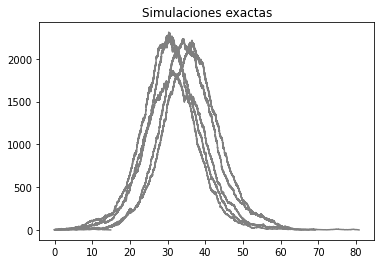

In [4]:
N=10**5
S_0=N-2
I_0=N-S_0
beta=1.25
gamma=1
for k in range(10):
    H=Gillespie_First_Reaction(N,S_0,I_0,1.25,1)
    while(len(H)<10):
        H=Gillespie_First_Reaction(N,S_0,I_0,1.25,1)
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray')
plt.title('Simulaciones exactas')
plt.show()

## Método directo para SIR markoviano en redes

In [3]:
import networkx as nx

In [35]:
N=10**2
G=nx.random_degree_sequence_graph(np.random.poisson(10,size=N))

In [36]:
np.random.seed(0)
X_I_indexes=np.random.choice(N,size=5,replace=False)

In [37]:
X_I_indexes
X_I=len(X_I_indexes)

In [38]:
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'

In [39]:
G.has_edge(0,1)

False

In [102]:
for i in G.neighbors(0):
    print(i)

38
54
5
11
89
79
83
84


In [88]:
#dict_num_contacts
dict_num_contacts = dict.fromkeys(range(X_I+1),[])
num_cont_inf_por_indice=np.zeros(N)
for i in range(N):
    if(i not in X_I_indexes): #No es infeccioso
        count_for_i=0
        for j in X_I_indexes:
            if (G.has_edge(i,j)):#Es un ocntacto Susceptible-infeccioso
                num_cont_inf_por_indice[i]+=1
                count_for_i+=1
        update_dict(dict_num_contacts,count_for_i,i)

In [90]:
#dict_num_contacts

In [ ]:
#Sabemos que el rango de K (el número de contactos infecciosos de un susceptible al tiempo $t$) está acotado por I(t):
#Generamos la partición(Del conjunto de susceptibles en riesgo). Orden O(K*N)
P=[]
for k in range(int(X_I)):
    P.append([i for i, j in enumerate(num_cont_inf_por_indice) if j == k])
#P[i] es el conjunto de indices de individuos que tienen exactamente $i$ contactos infecciosos.
#Esto se puede mejorar, no me interesa saber quiénes son, sólo cuántos (por ahora).

In [103]:
dict_num_contacts = dict.fromkeys(range(X_I+1),[])
num_cont_inf_por_indice=np.zeros(N)
for i in range(N):
    if(i not in X_I_indexes): #No es infeccioso
        count_for_i=0
        for j in X_I_indexes:
            if (G.has_edge(i,j)):#Es un ocntacto Susceptible-infeccioso
                num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                count_for_i+=1
        dict_num_contacts=update_dict_add(dict_num_contacts,count_for_i,i)

In [93]:
Lambda=0
beta=1.25
gamma=1
Lambdas=[]
for k in range(X_I+1):
    Lambdas.append(beta*len(dict_num_contacts[k])*k)
    Lambda+=Lambdas[-1]
Lambdas.append(gamma*X_I)
Lambda+=Lambdas[-1]
print(Lambdas)

[0.0, 48.75, 17.5, 0.0, 0.0, 0.0, 5]


In [4]:
def update_dict_add(dict_num_contacts,k,s_i):
    u= dict_num_contacts[k].copy()
    u.append(s_i)
    dict_num_contacts[k]=u
    return dict_num_contacts

In [5]:
def update_dict_remove(dict_num_contacts,k,s_i):
    u= dict_num_contacts[k].copy()
    u.remove(s_i)
    dict_num_contacts[k]=u
    return dict_num_contacts

In [6]:
def Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)#Tiempo de siguiente reacción, hasta ahora desconocida.
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            k+=1
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
        #k es el número de contactos infecciosos del seleccionado.
        #Seleccionamos uno aleatoriamente de ese grupo
        new_reaction=np.random.choice(dict_num_contacts[k])
    else:#Recuperación
        k=-1
        #Seleccionar un infeccioso al azar.
        new_reaction=np.random.choice(X_I_indexes)
    return tau,new_reaction,k
#Monte_Carlo_Step_exp(Lambdas)

In [7]:
def Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf):
    #X_R=N-X_S-X_I
    #tiempo
    flag=True
    t=0
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]#Focus
    dict_num_contacts = dict.fromkeys(range(X_I+1),[])
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts=update_dict_add(dict_num_contacts,count_for_i,i)
    #print(dict_num_contacts)
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append(beta*len(dict_num_contacts[k])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #print("tiempo generado",tau,new_reaction)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'
            X_I_indexes=np.append(X_I_indexes,new_reaction)
            #print('Infeccion actualizada')
            i=new_reaction
            #print(new_reaction,' infectado al tiempo ', tau, ' del grupo ', 'k=',k_choice)
            dict_num_contacts=update_dict_remove(dict_num_contacts,k_choice,i)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #print("Si removido")
            #Ahora a todos los individuos que tenian contacto con el nuevo infeccioso, les aumentamos un contacto infeccioso.
            num_max_cont=list(dict_num_contacts.keys())[-1]
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    #print('el vecino ', vecino, ' del nuevo infectado ', i,' tiene ', num_cont_del_vecino,' contactos')
                    if(num_cont_del_vecino+1>num_max_cont):
                        dict_num_contacts.update({num_cont_del_vecino+1:[vecino]})
                    else:
                        dict_num_contacts=update_dict_add(dict_num_contacts,num_cont_del_vecino+1,vecino)
                    #print('el vecino ', vecino, ' ya no tiene ', num_cont_del_vecino, ' asi que lo borramos')
                    dict_num_contacts=update_dict_remove(dict_num_contacts,num_cont_del_vecino,vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
        else:
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            X_I_indexes=np.delete(X_I_indexes,np.where(X_I_indexes == new_reaction))#Vale la pena pasarlo a lista para usar remove()?
            #print('Recuperacion actualizada')
            i=new_reaction
            #Hay que actualizar los números de contactos de los susceptibles que tenían contacto con este infeccioso.
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# no hay vecinos
                    dict_num_contacts=update_dict_add(dict_num_contacts,num_cont_del_vecino-1,vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
        t+=tau
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        #print(X_S)
        #print(dict_num_contacts)
        if(X_I==0):
            flag=False
    return Historia
        #-------------------------------------------

### Ejemplo

In [14]:
N=10**2
ksum=1
while(ksum%2!=0):#Que defina una grafica.
        k_dist=np.random.poisson(10,size=N)
        ksum=sum(k_dist)
G=nx.random_degree_sequence_graph(k_dist)
#np.random.seed(0)
X_I_indexes=np.random.choice(N,size=5,replace=False)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'

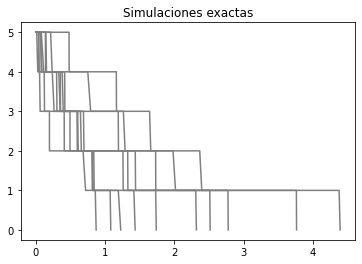

In [26]:
S_0=N-5
I_0=N-S_0
beta=1.25
gamma=1
for k in range(10):
    H=[]
    while(len(H)<20):
        H=Gillespie_Direct_Method_Network(beta=beta,gamma=gamma,N=N,X_I_indexes=X_I_indexes,G_network_initial=G,T=np.inf)
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray')
plt.title('Simulaciones exactas')
plt.show()

In [29]:
G.nodes.data()

NodeDataView({0: {'Estado:': 'Recuperado'}, 1: {'Estado:': 'Recuperado'}, 2: {'Estado:': 'Recuperado'}, 3: {'Estado:': 'Recuperado'}, 4: {'Estado:': 'Recuperado'}, 5: {'Estado:': 'Recuperado'}, 6: {'Estado:': 'Recuperado'}, 7: {'Estado:': 'Recuperado'}, 8: {'Estado:': 'Recuperado'}, 9: {'Estado:': 'Infeccioso'}, 10: {'Estado:': 'Recuperado'}, 11: {'Estado:': 'Recuperado'}, 12: {'Estado:': 'Recuperado'}, 13: {'Estado:': 'Infeccioso'}, 14: {'Estado:': 'Recuperado'}, 15: {'Estado:': 'Recuperado'}, 16: {'Estado:': 'Recuperado'}, 17: {'Estado:': 'Recuperado'}, 18: {'Estado:': 'Recuperado'}, 19: {'Estado:': 'Infeccioso'}, 20: {'Estado:': 'Recuperado'}, 21: {'Estado:': 'Recuperado'}, 22: {'Estado:': 'Recuperado'}, 23: {'Estado:': 'Recuperado'}, 24: {'Estado:': 'Recuperado'}, 25: {'Estado:': 'Recuperado'}, 26: {'Estado:': 'Infeccioso'}, 27: {'Estado:': 'Recuperado'}, 28: {'Estado:': 'Recuperado'}, 29: {'Estado:': 'Infeccioso'}, 30: {'Estado:': 'Recuperado'}, 31: {'Estado:': 'Recuperado'}, 32: 

In [ ]:
H

[[0, 995, 5], [0.007669482187925033, 994, 6]]

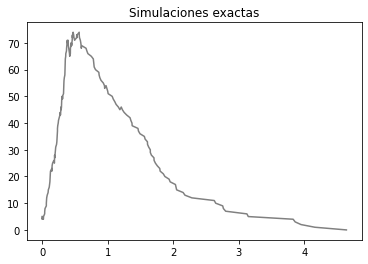

In [11]:
H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
plt.plot(H['time'],H['I(t)'], 'gray')
plt.title('Simulaciones exactas')
plt.show()

## Método directo para SIR no-markoviano.



## Método directo para SIR no-markoviano en redes